In [1]:
import os
import torch
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from bayesian_torch.models.dnn_to_bnn import dnn_to_bnn, get_kl_loss
from gradcam.utils import visualize_cam

/Users/julian/opt/anaconda3/envs/my_pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
num_classes = 3
model = torchvision.models.densenet121(weights='DEFAULT')
model.classifier = torch.nn.Linear(model.classifier.in_features, num_classes)
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [3]:
X = torch.rand(10, 3, 224,224)
output = model.forward(X)
m = torch.nn.Softmax(dim=1)
pred = m(output)
print(pred)

tensor([[0.2496, 0.3797, 0.3707],
        [0.3028, 0.3589, 0.3383],
        [0.3785, 0.2664, 0.3552],
        [0.3892, 0.2444, 0.3663],
        [0.2190, 0.4892, 0.2918],
        [0.3155, 0.3269, 0.3576],
        [0.3251, 0.3165, 0.3583],
        [0.2357, 0.3702, 0.3941],
        [0.3533, 0.2840, 0.3627],
        [0.1473, 0.4507, 0.4019]], grad_fn=<SoftmaxBackward0>)


# Load saved model and test Explainability techniques

In [4]:
from captum.attr import LRP, GuidedGradCam, IntegratedGradients, NoiseTunnel, LayerGradCam, LayerAttribution

In [5]:
class Args():
    def __init__(self, model, path_saved_model, num_classes, cuda_flag, opt, lr,weight_decay):
        self.model = model
        self.saved_model = path_saved_model
        self.classes = num_classes
        self.cuda = cuda_flag
        self.opt = opt
        self.lr = lr
        self.weight_decay= weight_decay

In [6]:
from utils.util import load_model
args = Args('DenseNet',
        '/Volumes/Elements/Experiments/models_COVID_Bayesian_NN/DenseNet20230130_1908/DenseNet_best_checkpoint.pth.tar',
        num_classes,
        False,
        'adam',
        2e-5,
        1e-7)
model,_,_ = load_model(args)

In [7]:
from PIL import Image, ImageOps
import cv2 

def load_image(img_path, norm=True):
    if not os.path.exists(img_path):
        print("IMAGE DOES NOT EXIST {}".format(img_path))
    image = cv2.imread(img_path)
    image2 = np.copy(image)
    image2[image2>0]=255
    image2 = image2[:,:,0]
    mask = Image.fromarray(image2.astype('uint8'))
  
    img_adapteq = Image.fromarray(image.astype('uint8'), 'RGB')
    img_adapteq = ImageOps.equalize(img_adapteq,mask=mask)
    if norm:
        preprocess = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),#normaliza a [0,1]
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
    else:
        preprocess = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),#normaliza a [0,1]
            #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
    image_tensor = preprocess(img_adapteq)

    return image_tensor

def normalize(x):
    _min, _max = x.min(), x.max()
    return (x - _min).div(_max - _min)

In [8]:
#img_path = '/Users/julian/Downloads/Datos/OrgImages/ACT__0__n__PA__CR__ANON1__1__ANON1.png'
#img_path = '/Users/julian/Downloads/Datos/OrgImages/HM1__1__n__AP__CR__2324__1__1.3.51.0.7.1715221929.6528.65088.46875.31980.21120.60010.DC3.png'
#img_path = '/Users/julian/Downloads/Datos/OrgImages/HM1__1__n__AP__CR__2322__2__1.3.51.0.7.13282468116.7861.28737.47437.6632.22177.63558.DC3.png'
#img_path = '/Users/julian/Downloads/Datos/OrgImages/CRXNIH__2__n__DX__PA__30398__0__00030398_000.png'
#img_path = '/Users/julian/Downloads/Imágenes/HM2__1__n__AP__CR__901__3__1.3.51.0.7.2116492664.37677.6978.37078.42691.64186.46727.DC3.png'
img_path = '/Users/julian/Downloads/Imágenes/HM2__1__n__AP__CR__954__2__1.3.51.0.7.923658696.26576.13891.44559.10568.29024.48676.DC3.png'
#img_path = '/Users/julian/Downloads/Imágenes/HM2__1__n__AP__CR__954__2__1.3.51.0.7.923658696.26576.13891.44559.10568.29024.48676.DC3_Inpainting.png'
#img_path = '/Users/julian/Downloads/Imágenes/BIMCV__1__n__AP__3862__7800__1__DX.png'

In [9]:
#COVIDxDICT = {'pneumonia': 0, 'normal': 1, 'COVID-19': 2}
target = torch.tensor([2])

In [10]:
img = load_image(img_path,False)

In [11]:
channels, in_height, in_width = img.shape

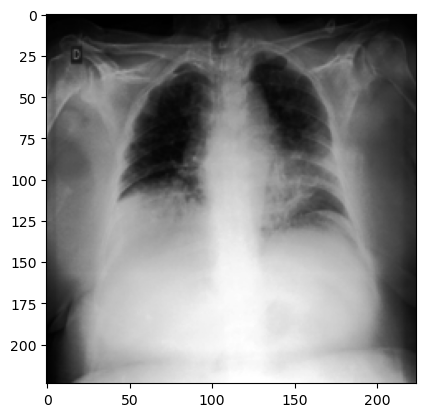

In [12]:
img_toplot = np.moveaxis(img.cpu().detach().numpy(), 0, -1)
plt.imshow(img_toplot)
plt.show()

In [13]:
img = load_image(img_path,True)
model.eval()
lrp = LRP(model)
attribution = lrp.attribute(torch.unsqueeze(img,0), target=target)

/Users/julian/opt/anaconda3/envs/my_pytorch/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


In [14]:
model(torch.unsqueeze(img,0))

tensor([[ -2.9842, -10.3882,   9.8889]], grad_fn=<AddmmBackward0>)

In [15]:
attribution.sum()

tensor(1.8838, grad_fn=<SumBackward0>)

In [16]:
torch.nn.functional.softmax(model(torch.unsqueeze(img,0)),dim=-1)

tensor([[2.5662e-06, 1.5624e-09, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)

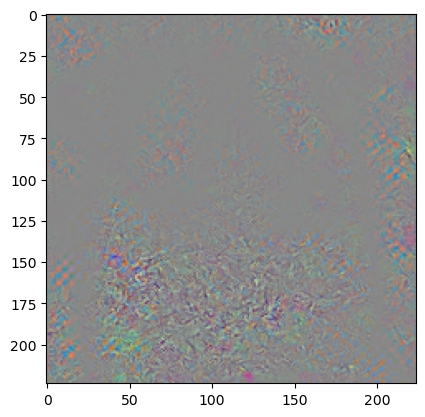

In [17]:
img_lrp = np.moveaxis(np.squeeze(attribution.cpu().detach().numpy()), 0, -1)
img_lrp = (img_lrp - img_lrp.min(axis=(0,1,2), keepdims=True))/(img_lrp.max(axis=(0,1,2), keepdims=True)-img_lrp.min(axis=(0,1,2), keepdims=True))
plt.imshow(img_lrp)
plt.show()

In [18]:
img_lrp.sum()

80329.43

In [19]:
guided_gc = GuidedGradCam(model, model.features.denseblock4.denselayer16.conv2)
attribution = guided_gc.attribute(torch.unsqueeze(img,0), target)

/Users/julian/opt/anaconda3/envs/my_pytorch/lib/python3.9/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


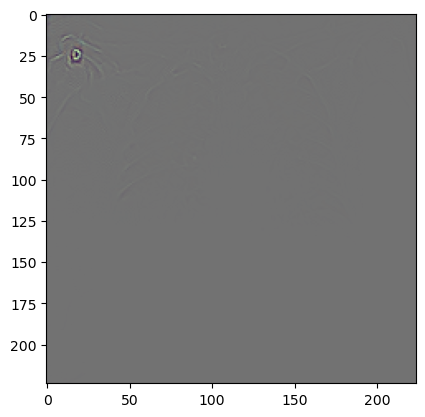

In [20]:
img_lrp = np.moveaxis(np.squeeze(attribution.cpu().detach().numpy()), 0, -1)
img_lrp = (img_lrp - img_lrp.min(axis=(0,1,2), keepdims=True))/(img_lrp.max(axis=(0,1,2), keepdims=True)-img_lrp.min(axis=(0,1,2), keepdims=True))
plt.imshow(img_lrp)
plt.show()

In [21]:
integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(torch.unsqueeze(img,0), target=target, n_steps=200)

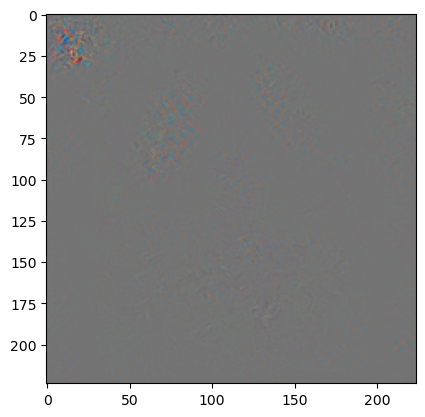

In [22]:
img_lrp = np.moveaxis(np.squeeze(attributions_ig.cpu().detach().numpy()), 0, -1)
img_lrp = (img_lrp - img_lrp.min(axis=(0,1,2), keepdims=True))/(img_lrp.max(axis=(0,1,2), keepdims=True)-img_lrp.min(axis=(0,1,2), keepdims=True))
plt.imshow(img_lrp)
plt.show()

In [23]:
noise_tunnel = NoiseTunnel(integrated_gradients)
attributions_ig_nt = noise_tunnel.attribute(torch.unsqueeze(img,0), nt_samples=10, nt_type='smoothgrad_sq', target=target)

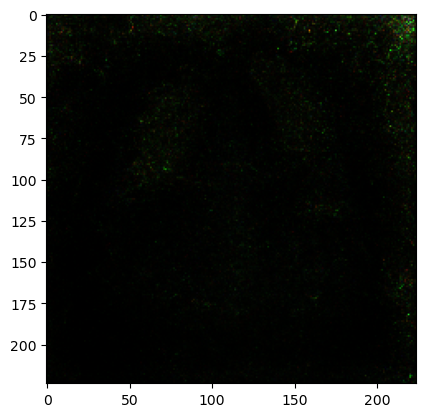

In [24]:
img_lrp = np.moveaxis(np.squeeze(attributions_ig_nt.cpu().detach().numpy()), 0, -1)
img_lrp = (img_lrp - img_lrp.min(axis=(0,1,2), keepdims=True))/(img_lrp.max(axis=(0,1,2), keepdims=True)-img_lrp.min(axis=(0,1,2), keepdims=True))
plt.imshow(img_lrp)
plt.show()

In [25]:
gradcam = LayerGradCam(model, model.features.denseblock4.denselayer16.conv2)
attribute_gradcam = gradcam.attribute(torch.unsqueeze(img,0), 
                                      target=target,
                                      relu_attributions=True)

In [26]:
attribute_gradcam = LayerAttribution.interpolate(attribute_gradcam, 
                                                 (in_height, in_width),
                                                 'bilinear')
attribute_gradcam = normalize(attribute_gradcam)

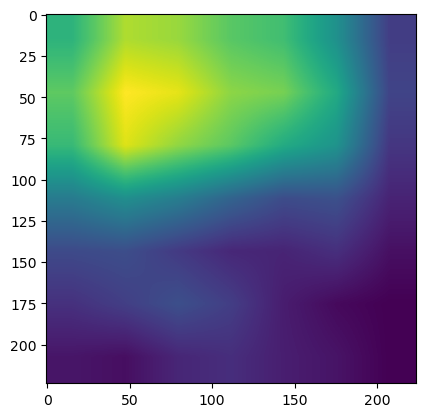

In [27]:
img_lrp = np.squeeze(attribute_gradcam.cpu().detach().numpy())
img_lrp = (img_lrp - img_lrp.min(axis=(0,1), keepdims=True))/(img_lrp.max(axis=(0,1), keepdims=True)-img_lrp.min(axis=(0,1), keepdims=True))
plt.imshow(img_lrp)
plt.show()

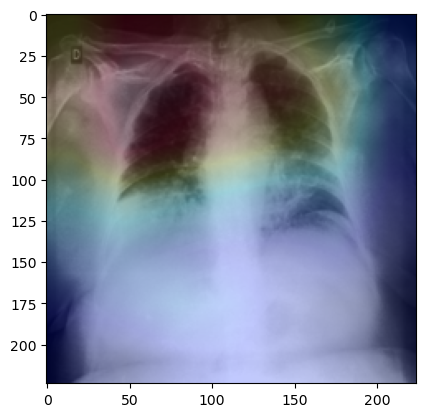

In [28]:


heatmap, result = visualize_cam(attribute_gradcam,
                                img,
                                1)
result = normalize(result)
plt.imshow(result.detach().numpy().transpose(1, 2, 0))
plt.show()

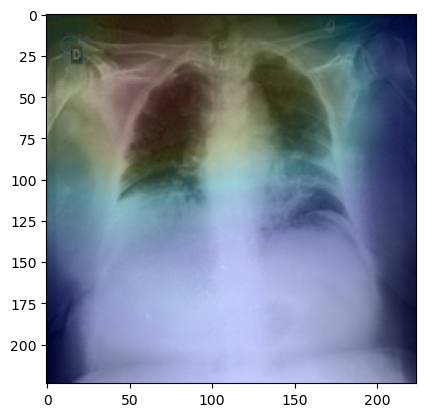

In [29]:
alpha = 0.5
lwrp = normalize(attributions_ig.sum(axis=1)).detach().cpu().numpy()
attribution_c = (attribute_gradcam.detach().numpy())*(1-alpha)+lwrp*alpha
#attribution_c= attribution_c.mean(axis=1)
attribution_c = torch.unsqueeze(normalize(torch.tensor(attribution_c,requires_grad=True)),0)

heatmap, result = visualize_cam(attribution_c,
                                img,
                                1)
result = normalize(result)
plt.imshow(result.detach().numpy().transpose(1, 2, 0))
plt.show()

# Versión bayesiana del modelo

In [30]:
args = Args('BDenseNet',
        '/Volumes/Elements/Experiments/models_COVID_Bayesian_NN/BDenseNet20230201_0923/BDenseNet_best_checkpoint.pth.tar',
        num_classes,
        False,
        'adam',
        2e-5,
        1e-7)
modelb,_,_ = load_model(args)

In [31]:
modelb.eval()
num_monte_carlo = 20
with torch.no_grad():
    output_mc = []
    for mc_run in range(num_monte_carlo):
        logits = modelb(torch.unsqueeze(img,0))
        probs = torch.nn.functional.softmax(logits, dim=-1)
        output_mc.append(probs)
    output = torch.stack(output_mc)  
    pred_mean = output.mean(dim=0)
    y_pred = torch.argmax(pred_mean, axis=-1)
    test_acc = (y_pred.data.cpu().numpy() == target.data.cpu().numpy()).mean()

In [32]:
pred_mean

tensor([[1.8107e-04, 9.8904e-06, 9.9981e-01]])

In [33]:
y_pred

tensor([2])

In [34]:
test_acc

1.0

In [35]:
from utils.util_btorch import predictive_entropy, mutual_information

predictive_uncertainty = predictive_entropy(output.data.cpu().numpy())
model_uncertainty = mutual_information(output.data.cpu().numpy())

In [36]:
predictive_uncertainty

array([0.00186506], dtype=float32)

In [37]:
model_uncertainty

array([0.00047861], dtype=float32)

## Muestreo de modelos

In [38]:
from model.bnn_to_dnn import bnn_to_dnn

In [39]:
model_list = []
for mc_run in range(num_monte_carlo):
    modelbd,_,_ = load_model(args)
    bnn_to_dnn(modelbd)
    model_list.append(modelbd)

In [40]:
output_mc = []

for model in model_list:
    model.eval()
    logits = model(torch.unsqueeze(img,0))
    probs = torch.nn.functional.softmax(logits, dim=-1)
    output_mc.append(probs)
output = torch.stack(output_mc)  
pred_mean = output.mean(dim=0)
y_pred = torch.argmax(pred_mean, axis=-1)
test_acc = (y_pred.data.cpu().numpy() == target.data.cpu().numpy()).mean()
print(test_acc)

1.0


In [41]:
pred_mean

tensor([[3.4362e-04, 4.7588e-05, 9.9961e-01]], grad_fn=<MeanBackward1>)

In [42]:
y_pred

tensor([2])

In [43]:
predictive_uncertainty = predictive_entropy(output.data.cpu().numpy())
model_uncertainty = mutual_information(output.data.cpu().numpy())

In [44]:
predictive_uncertainty

array([0.00360548], dtype=float32)

In [45]:
model_uncertainty

array([0.00105465], dtype=float32)

In [46]:
gradcam_mc = []
#i_gradcam_mc = []
for k,model in enumerate(model_list):
    #print(k)
    model.eval()
    #lrp = LRP(model)
    #attribution = lrp.attribute(torch.unsqueeze(img,0), target=target)
    #gradcam_mc.append(normalize(attribution.sum(axis=1)))
    #---------------------------------------------------------------------------------------------------
    #integrated_gradients = IntegratedGradients(model)
    #attributions_ig = integrated_gradients.attribute(torch.unsqueeze(img,0), target=target, n_steps=200)
    #i_gradcam_mc.append(normalize(attributions_ig.sum(axis=1)))
    #---------------------------------------------------------------------------------------------------
    gradcam = LayerGradCam(model, model.features.denseblock4.denselayer16.conv2)
    attribute_gradcam = gradcam.attribute(torch.unsqueeze(img,0), 
                                          target=target,
                                          relu_attributions=True)
    attribute_gradcam = LayerAttribution.interpolate(attribute_gradcam, 
                                                 (in_height, in_width),
                                                 'bilinear')
    gradcam_mc.append(normalize(attribute_gradcam))
gradcam = torch.stack(gradcam_mc)
#i_gradcam = torch.stack(i_gradcam_mc)

In [47]:
#alpha = 0.5
#lwrp = i_gradcam.sum(axis=0).detach().cpu().numpy()
attribution_c = gradcam.sum(axis=0).detach().numpy()#(gradcam.sum(axis=0).detach().numpy())*(1-alpha)+lwrp*alpha
attribution_c = torch.unsqueeze(normalize(torch.tensor(attribution_c,requires_grad=True)),0)

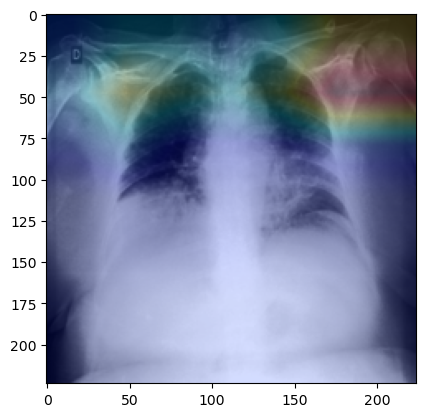

In [48]:
heatmap, result = visualize_cam(attribution_c,
                                img,
                                1)
result = normalize(result)
plt.imshow(result.detach().numpy().transpose(1, 2, 0))
plt.show()

In [49]:
#lwrp = i_gradcam.std(axis=0).detach().cpu().numpy()
attribution_c = gradcam.std(axis=0).detach().numpy()#(gradcam.std(axis=0).detach().numpy())*(1-alpha)+lwrp*alpha

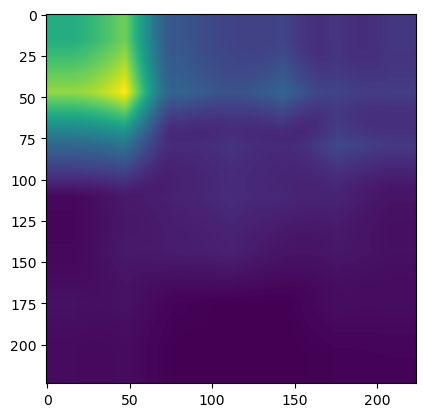

In [50]:
plt.imshow(np.squeeze(2*attribution_c))

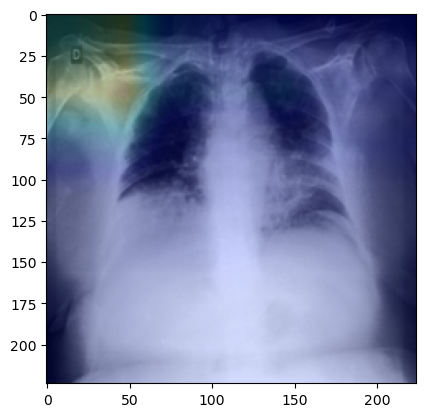

In [51]:
attribution_c = torch.unsqueeze(normalize(torch.tensor(attribution_c,requires_grad=True)),0)
heatmap, result = visualize_cam(2*gradcam.std(axis=0),
                                img,
                                1)
result = normalize(result)
plt.imshow(result.detach().numpy().transpose(1, 2, 0))
plt.show()